In [1]:
import h5py
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as colors
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from collections import Counter
import seaborn
import random

# custom libs
from Task_1 import custom_log_reg
from Task_1 import decision_chimney_kids


import numpy as np
import warnings


# suppress warnings since we are using exp and large number for the first iterates! 
warnings.filterwarnings('ignore')

# Task 1: build a kernelized logistic regressor

To implement the kernel logistic regression I created a dedicate class which contained 3 modules:

- **fit:** the function first cast the input to a numpy.array (I added this part since it is easier to handle data in a pandas DF format) and then I saved the number of instances (m). Then I computed the kernel matrix with the function that was instantiated when initializing the function using the keywords "gaussian" or "linear" (notice that only a RBF and a Linear Kernel are implemented at the moment! The kernel matrix is then saved inside the class. To add more kernel it is necessary to update the __init__ module of the class and to create the appropriate kernel function. I did not add them since only the RBF kernel was requested, but I implemented a scalable function, as requested in the assignment). Then I initialize a vector of zeros for the alpha weights with the same dimension as the numebr of instances. Subsequently I implemented the GD with adaptive learning (executed for max_iter iterations times - or when the control condition was satisfied!) computing the gradient of the logistic regression cost function (see the code for the math). The tuned weights are saved inside the class and are available for the next parts.

- **predict_prob:** the function computes the sigmoid of the dot product between the trained alphas and the already computed kernel matrix, those are the probabilities.

- **predict:** calls predict_prob to get the probabilities and then applies a threshold to get the labels in the binary classification problem

# Import data

In [2]:
random.seed(42)

hf = h5py.File("regression.h5", "r")
x_train = np.array(hf.get("x_train"))
y_train_double = np.array(hf.get("y_train"))
x_test = np.array(hf.get("x_test"))
y_test_double = np.array(hf.get("y_test"))
hf.close()

y_train_double = np.stack(y_train_double, axis=1 )
y_test_double = np.stack(y_test_double, axis=1 )



# scale the data
my_scaler = StandardScaler()
x_train = my_scaler.fit_transform(x_train)
x_test = my_scaler.transform(x_test)

# create a pandas df
columns = ["x", "y", "age_house", "carbon_emission", "dist_school", "avg_child_neigh"]
x_train = pd.DataFrame(x_train, columns = columns)
x_test = pd.DataFrame(x_test, columns = columns)
y_train = pd.Series(y_train_double[0], name="Chimney")
y_test = pd.Series(y_test_double[0], name="Chimney")

# create the ML dataframes for task 1.1
x_train_1 = x_train.loc[:, ['x', 'y']]
x_test_1 = x_test.loc[:, ['x', 'y']]

x_train.head()

,x,y,age_house,carbon_emission,dist_school,avg_child_neigh
0,-0.669235,0.587037,-0.308047,0.419225,-0.157499,1.232679
1,0.163470,0.056132,0.219397,-0.846478,0.098121,-0.053275
2,-0.416195,-0.665074,-0.693418,0.619204,-0.247523,0.314140
3,-0.211262,0.946100,-0.720322,-0.452048,-0.736259,-1.247376
4,-0.207527,-0.887538,-1.557995,-0.608554,-0.825437,-1.155522


# Subtask 1: Kernelized Logistic Regression

-----------------------------------
The accuracy score on train resulted to be: 0.984
The accuracy score on test resulted to be: 0.826
-----------------------------------


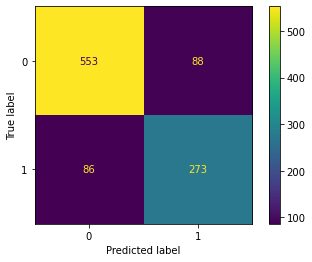

In [3]:
# set my parameters
maxIter = 100
sigma = 0.05
alpha = np.zeros(4)

# create the ML dataframes
x_train_1 = x_train.loc[:, ['x', 'y']]
x_test_1 = x_test.loc[:, ['x', 'y']]

my_log_reg = custom_log_reg(kernel='gaussian', hyper_kernel=sigma)
costs = my_log_reg.fit(X=x_train_1, y=y_train, max_steps=maxIter, Lambda = 0.001, epsilon=1e-6)

# assess the results!
Z = my_log_reg.predict(x_test_1, threshold=0.5)
Z_train = my_log_reg.predict(x_train_1, threshold=0.5)

print("-----------------------------------")
print("The accuracy score on train resulted to be: {}".format(accuracy_score(Z_train, y_train)))
print("The accuracy score on test resulted to be: {}".format(accuracy_score(Z, y_test)))
print("-----------------------------------")

# plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(Z, y_test))
disp.plot()

# subtask 2: get better results!

In this task we use all the training data to do the regression. Since we are using a lot of features we need to have fast kernel computations i.e. not computing puntually each element of the kernel matrix! A nice way to do that is using the fact that you can compute the norm of each element of the design matrix and storing it. This avoid to compute the norm each iteration saving time, in fact that ||x_i-x_j||^2 = ||x_i||^2 + ||x_j||^2 - 2 * x_i^T * x_j.
I also implemented the operations s.t. we are using matrix notation, making it more readable.

I decided to use a custom kernel structured as the sum of two different gaussian kernels: the first kernel was computed using only the first two features (i.e. x and y) while the second kernel was computed using only the last 4 features (i.e. the remaining ones). The intuition behind it is that the logistic regression computed only on the x and y data was already good enough (see the test accuracy in the previous exercise!) so I wanted to somehow add new information to better the prediction. The strategy proved to be effective.

The hyperparameter of the kernel are:

- sigma of the first gaussian kernel
- sigma of the second gaussian kernel
- multiplicative factor for the second hyperparameter

I chose not to do a cross validation because I wanted to try different hyperparameters (I had very few ideas about which could have been useful hyperparameter, so I chose a log-scaled grid!) and the computational time was high. Ideally a grid search CV would be preferable.

After a couple of numerical experiments I found out that a threshold value of 0.4 is really effective in generalizing well.

In [4]:
# set my parameters
maxIter = 100
sigma_1 = 0.1
sigma_2 = 0.1
para_sum = 1
Lambda = 0.0001
alpha = np.zeros(4)

my_log_reg = custom_log_reg(kernel='custom', hyper_kernel=(sigma_1, sigma_1, para_sum))
costs = my_log_reg.fit(X=x_train, y=y_train, max_steps=maxIter, Lambda = Lambda, epsilon=1e-6)

-----------------------------------
The accuracy score on train resulted to be: 1.0
The accuracy score on test resulted to be: 0.833
-----------------------------------


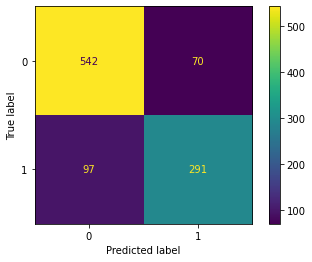

In [5]:
# assess the results!
Z = my_log_reg.predict(x_test, threshold=0.4)
Z_train = my_log_reg.predict(x_train, threshold=0.4)

print("-----------------------------------")
print("The accuracy score on train resulted to be: {}".format(accuracy_score(Z_train, y_train)))
print("The accuracy score on test resulted to be: {}".format(accuracy_score(Z, y_test)))
print("-----------------------------------")

# plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(Z, y_test))
disp.plot()

<AxesSubplot:ylabel='Count'>

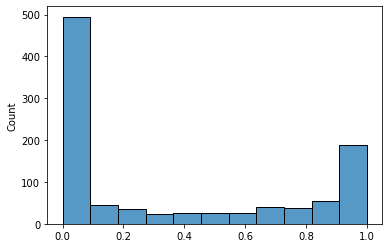

In [6]:
Z = my_log_reg.predict_prob(x_test)
seaborn.histplot(Z)

# Try some Grid_search parameter selection!

In [7]:
# set my parameters
maxIter = 200

grid_sigma1 = [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1]
grid_sigma2 = [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1]
grid_sum = [0, 0.25, 0.5, 0.75, 1]
grid_Lambda = [1e-5, 1e-3, 1e-1, 1]
grid_threshold = [0.4, 0.5, 0.6]

params = []
accuracies_test = []
accuracies_train = []

num_train = len(grid_sigma1) * len(grid_sigma2) * len(grid_sum) * len(grid_Lambda) * len(grid_threshold)
counter = 1

for sigma_1 in grid_sigma1:
    for sigma_2 in grid_sigma2:
        for para_sum in grid_sum:
            for Lambda in grid_Lambda:
                for threshold in grid_threshold:
                    my_log_reg = custom_log_reg(kernel='custom', hyper_kernel=(sigma_1, sigma_2, para_sum))
                    costs = my_log_reg.fit(X=x_train, y=y_train, max_steps=maxIter, Lambda = Lambda, epsilon = 1e-4)
                    
                    # assess the results!
                    Z = my_log_reg.predict(x_test, threshold=threshold)
                    Z_train = my_log_reg.predict(x_train, threshold=threshold)
                    
                    # saving accuracies and settings
                    accuracies_test.append(accuracy_score(y_test, Z))
                    accuracies_train.append(accuracy_score(y_train, Z_train))
                    params.append({
                        "sigma_spatial" : sigma_1,
                        "sigma_total" : sigma_2,
                        "sum_factor" : para_sum,
                        "Lambda" : Lambda,
                        "Threshold" : threshold
                    })
                    
                    # progresses
                    print("Trainigs done : {} / {}".format(counter, num_train), end="\r")
                    counter += 1

In [8]:
print("The best test result is {} with the following hyperparameters:".format(max(accuracies_test)))
index_max = np.argmax(accuracies_test)
print(params[index_max])

The best test result is 0.877 with the following hyperparameters:
{'sigma_spatial': 0.1, 'sigma_total': 1, 'sum_factor': 0.25, 'Lambda': 0.001, 'Threshold': 0.4}


# Subtask 3: support planning 1

We compute the expected cost of a delivary for any possible set of actions:

I can define p(x) = P( house has a chimney | x )

Therefore:

$E [cost(delivered)] = 0 * p(x) + 10 * (1 - p(x)) $

while

$E [cost(not$ $delivered)] = 1 * p(x) + 1 * (1 - p(x)) = 1$

We can see that the cost for delivering in smaller than the cost for non delivering if:

$E [cost(delivered)] < E [cost(not delivered)]$ $ \iff$ $p(x) > \frac{9}{10}$

This means that Santa should decide to go to places where the algorithm predicts that there is a likelyhood bigger than 0.9 to find a chimney in order to minimize the cost given the above contrains.

# All the validation set!

In [9]:
# train the best logistic regressor
my_log_chimney = custom_log_reg(kernel='custom', hyper_kernel=(0.1, 1, 0.25))
costs = my_log_chimney.fit(X=x_train, y=y_train, max_steps=2000, Lambda = 0.1, epsilon = 1e-4)

In [10]:
# cost matrix
C = np.matrix([[0, 10], [1, 1]])

# compute the expected cost on the whole validation set (In the assignment there is explicitly written to use
# all the validation set and not only the 50 houses Santa can visit)
best_costs, decisions = my_log_chimney.decide_chimney(x_test, C)
print("The sum of the expected cost on all the validation dataset is: {}".format(np.sum(best_costs)))

The sum of the expected cost on all the validation dataset is: 949.382097339962


# A random subsample of k elements

In [37]:
# constrain
k = 50

iter_random = []
costs = []
# consider the mean of 50 iterations!
for _ in range(50):
    list_of_random_items = random.sample(list(y_test_double[0]), k)
    # expected costs for the delivery
    for i in list_of_random_items:
        if i == 1:
            costs.append(0)
        elif i == 0:
            costs.append(10)
            
    iter_random.append(np.sum(costs))
    costs = []
    
print("The expected cost for {} randomly sampled houses over 50 iterations is: {}".format(k, np.mean(iter_random)))

The expected cost for 50 randomly sampled houses over 50 iterations is: 323.8


The expected cost results to be much lower than the one on the whole dataset, this is maily due to the fact that we are 
considering a subsample of dimension 50. We can clearly see that the main decision done by santa is to skip most of the houses because the likelyood that they have a chimney is too low.

On the total dataset Santa would delivery: 99


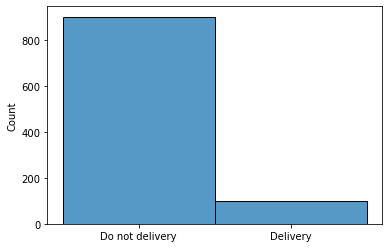

In [12]:
seaborn.histplot(decisions)
print("On the total dataset Santa would delivery: {}".format(decisions.count('Delivery')))

In [13]:
counter = 0
for i in range(len(decisions)):
    if y_test_double[0][i] == 1 and y_test_double[1][i] == 1 and decisions[i] == "Delivery":
        counter += 1
    
print("Among the delivered houses the number of houses that have kids is: {}".format(counter))

Among the delivered houses the number of houses that have kids is: 53


It is important to notice that santa can deliver a present only if the house has a chimney

# Subtask 4

In [14]:
# I use the rules given by the progessor in the order he gave them. I save them into a list!
cost_children = [0, 5, 2, 10, 20, 10, 10, 5]

In [15]:
# train the best logistic regressor to predict the presence of children
my_log_kids = custom_log_reg(kernel='custom', hyper_kernel=(0.1, 1, 0.25))
costs = my_log_kids.fit(X=x_train, y=y_train_double[1], max_steps=2000, Lambda = 0.1, epsilon = 1e-4)

<AxesSubplot:ylabel='Count'>

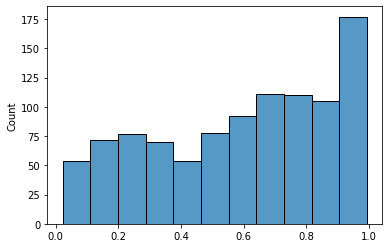

In [16]:
Z = my_log_kids.predict_prob(x_test)
seaborn.histplot(Z)

In [17]:
best_costs, decisions = decision_chimney_kids(x_test, log_kids=my_log_kids, log_chimneys = my_log_chimney, cost_vector = cost_children)

In [25]:
# constrain
k = 50

iter_random = []
# consider the mean of 50 iterations!
for _ in range(6):
    list_of_random_items = random.sample(list(zip(y_test_double[0], y_test_double[1])), k)
    # expected costs for the delivery
    costs = []
    for i in list_of_random_items:
        i = np.array(i)
        print
        if i[0] == 1 and i[1] == 1:
            costs.append(0)
        elif i[0] == 1 and i[1] == 0:
            costs.append(5)
        elif i[0] == 0 and i[1] == 1:
            costs.append(2)
        elif i[0] == 0 and i[1] == 0:
            costs.append(10)
            
        iter_random.append(np.sum(costs))
    
print("The expected cost for {} randomly sampled houses over 50 iterations is: {}".format(k, np.mean(iter_random)))

The expected cost for 50 randomly sampled houses over 50 iterations is: 103.86333333333333


In [15]:
seaborn.histplot(decisions)
print("On the total dataset Santa would deliver: {}".format(decisions.count('Delivery')))

NameError: name 'decisions' is not defined

In [20]:
counter = 0
for i in range(len(decisions)):
    if y_test_double[0][i] == 1 and y_test_double[1][i] == 1 and decisions[i] == "Delivery":
        counter += 1
    
print("Among the delivered houses the number of houses that have kids is: {}".format(counter))

Among the delivered houses the number of houses that have kids is: 198
